In [81]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


In [149]:


%matplotlib inline

import math, time, random, datetime

import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv
import time
def timer(self, threshold):
    if (time.time() - self.lastTime) > threshold:
        self.lastTime = time.time()
        return True
    else:
        return False
# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

# Data uploading and understanding

KNOWING THE DATA IN TABLE

VARIABLE DESCRIPTIONS:
* survival    :   Survival
                (0 = No; 1 = Yes)
                 
* pclass       :   Passenger Class
                 (1 = 1st; 2 = 2nd; 3 = 3rd)
                 
* name         :  Name
* sex          :  Sex
*  age         :   Age
 
* sibsp        :  Number of Siblings/Spouses Aboard
* parch        :  Number of Parents/Children Aboard
 
* ticket       :  Ticket Number
* fare         :  Passenger Fare
* cabin        :   Cabin
* embarked     : Port of Embarkation
                 (C = Cherbourg; Q = Queenstown; S = Southampton)

DATA LOADING

In [83]:
df_gender=pd.read_csv("/kaggle/input/titanic/gender_submission.csv")
df_test=pd.read_csv("/kaggle/input/titanic/test.csv")
df_train=pd.read_csv("/kaggle/input/titanic/train.csv")

 # UNDERSTANING THE DATASETS/

Lenght of my dataset's (the number of rows present )

In [84]:
len(df_gender) #length of gender table


418

In [85]:
len(df_test)  #lenght of test table

418

In [86]:
len(df_train) #length of train table

891

In [87]:
df_train.head(11)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [88]:
df_test.head(11)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


In [89]:
df_gender.head(11)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [90]:
df_gender.describe().columns


Index(['PassengerId', 'Survived'], dtype='object')

In [91]:
df_train.describe().columns


Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [92]:
df_test.describe().columns


Index(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

# Graphic representation of the basic data

## HELPS US UNDERSTAND VARIOUS ASPECT OF THE TABLE WITH THE HELP OF GRAPHS

CREATE DUPLICATE DATAFRAME

In [93]:
df_num = df_train[['Age','SibSp','Parch','Fare','Survived']]
df_cat = df_train[['Survived','Pclass','Sex','Ticket','Cabin','Embarked']]

GRAPH

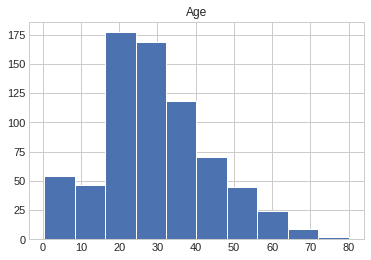

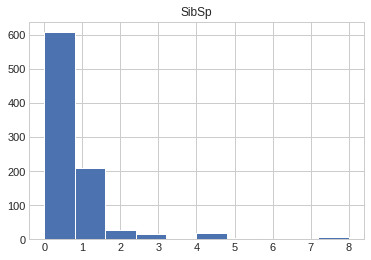

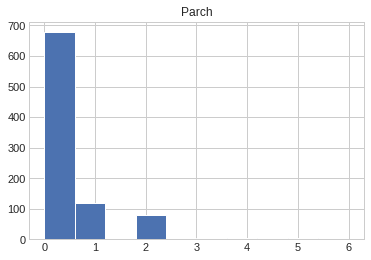

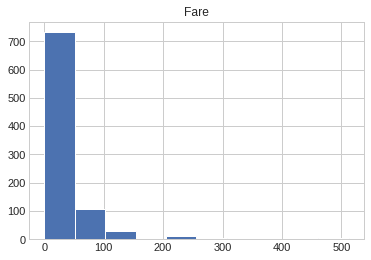

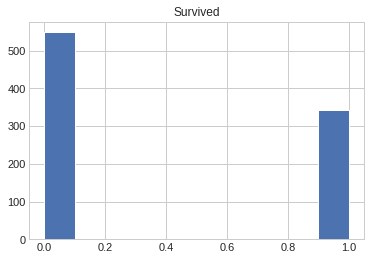

In [94]:
for i in df_num.columns:
    plt.hist(df_num[i])
    plt.title(i)
    plt.show()

               Age     SibSp     Parch      Fare  Survived
Age       1.000000 -0.308247 -0.189119  0.096067 -0.077221
SibSp    -0.308247  1.000000  0.414838  0.159651 -0.035322
Parch    -0.189119  0.414838  1.000000  0.216225  0.081629
Fare      0.096067  0.159651  0.216225  1.000000  0.257307
Survived -0.077221 -0.035322  0.081629  0.257307  1.000000


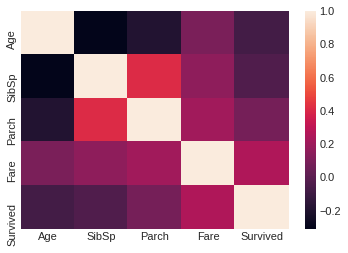

In [95]:

print(df_num.corr())
sns.heatmap(df_num.corr())

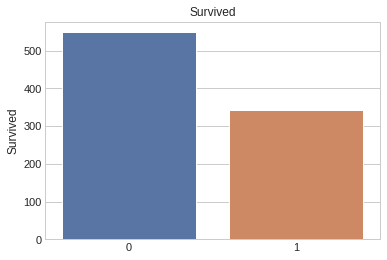

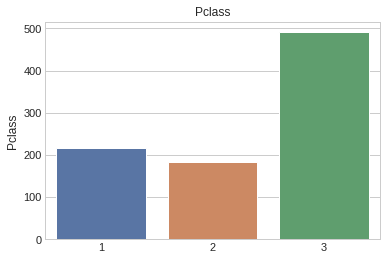

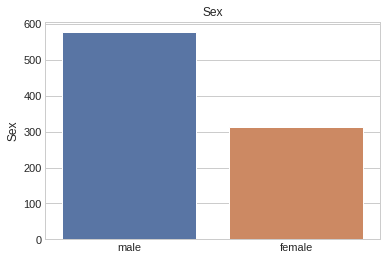

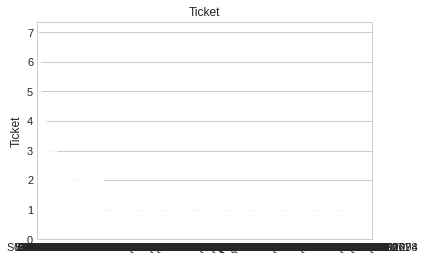

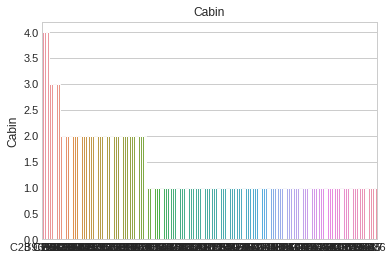

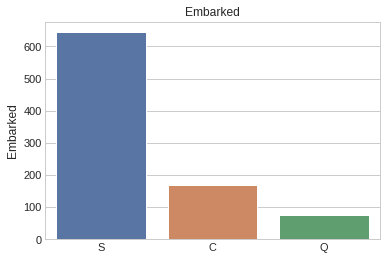

In [96]:
for i in df_cat.columns:
    sns.barplot(df_cat[i].value_counts().index,df_cat[i].value_counts()).set_title(i)
    plt.show()

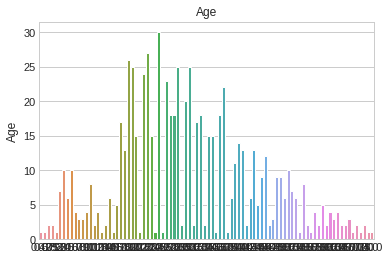

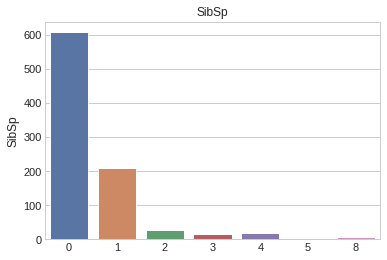

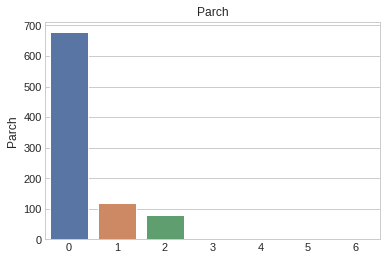

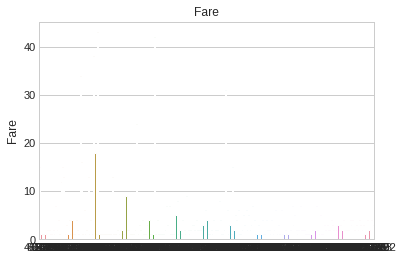

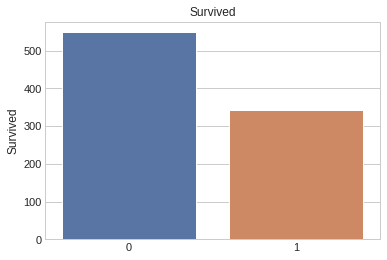

In [97]:
for n in df_num.columns:
    sns.barplot(df_num[n].value_counts().index,df_num[n].value_counts()).set_title(n)
    plt.show()

## IDENTIFICATION OF NULL VALUES 


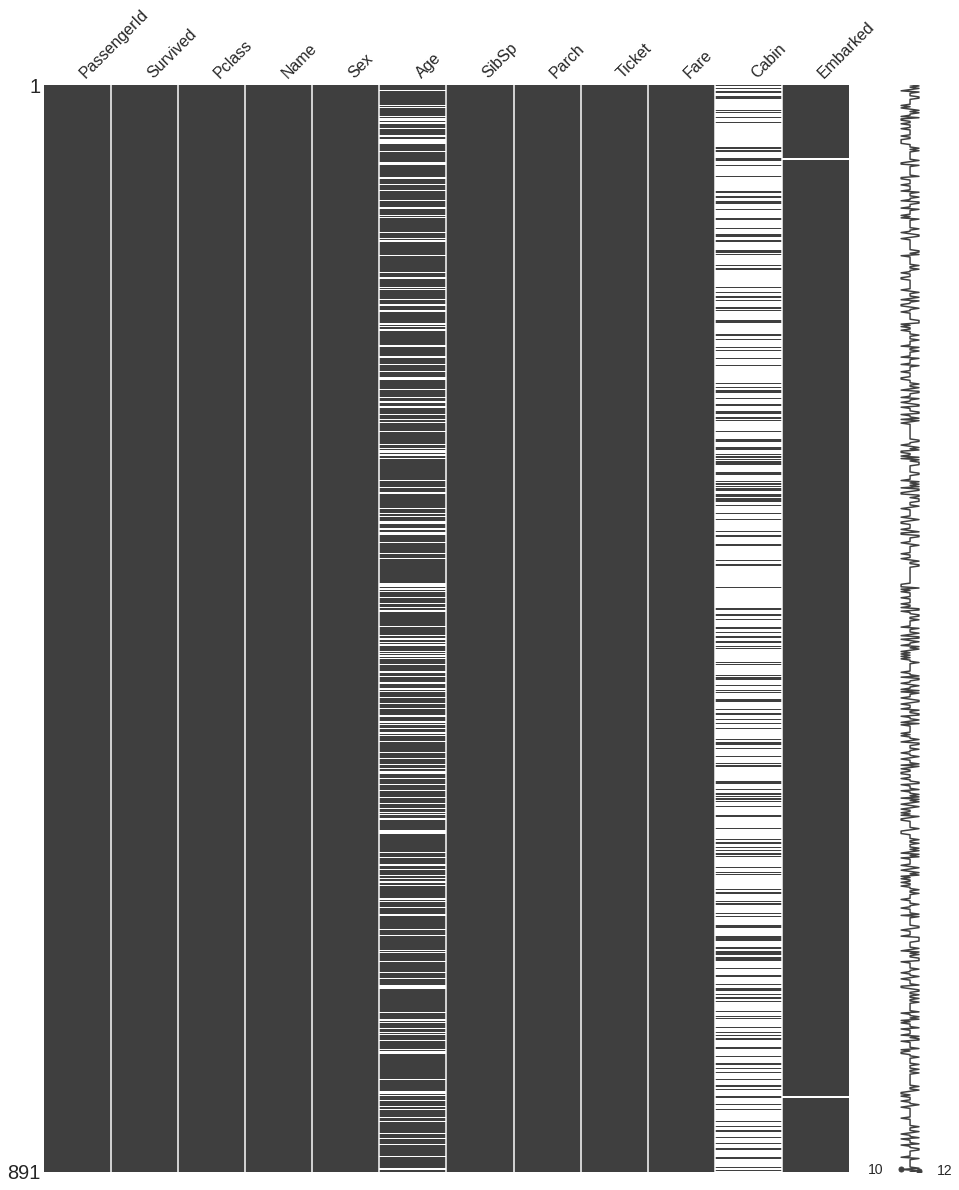

In [98]:
missingno.matrix(df_train, figsize = (16,20))

THE BLACK SHOWED FILLED DATA AND  THE WHITE SPACES SHOWS THE FIELDS WITH NULL VALUE , WE CAN SEE THAT AGE AND CABIN HAVE LOTS OF MISSING AND INCONSISTANT DATA


THE SAME CONCLUSION IS SHOWN BELOW IN NUMERIC FORMS

In [99]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### CREATE 2nd DUPLICATE DATAFRAME FOR ANALYSIS

In [100]:
df_bin=pd.DataFrame()
df_con=pd.DataFrame()

In [101]:
df_train.dtypes


PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

# ANALYSIS OF FEATURES
With the help of graphs we get to know the data better and can make better decisions

### Survied people

NOTE:-  0 = Deseacead, 1 = survived

In [120]:
df_train.Survived.isnull().sum()

0

In [103]:
df_train.Survived.value_counts()       # count or number of survived passanger


0    549
1    342
Name: Survived, dtype: int64

FROM THE ABOVE NUMBERS WE CAN SEE THAT 

1. survied = 549
2. deaseced =342 


Plotted below for graphical represent



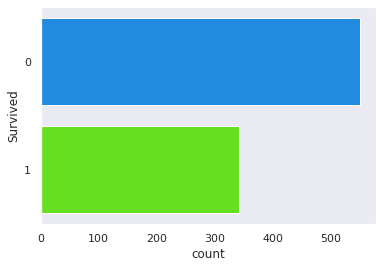

In [104]:
sns.set(style='dark')
ax=sns.countplot(y='Survived' ,palette='gist_rainbow_r', data=df_train);

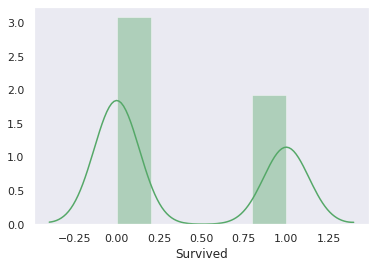

In [105]:
sns.distplot(df_train.Survived , color = 'g')

In [106]:
df_bin['Survived'] = df_train['Survived']
df_con['Survived'] = df_train['Survived']   #add data to our subset dataframes

## Pclass

NOTE:-The ticket class of the passenger.

Key: 1 = 1st,
     2 = 2nd, 
     3 = 3rd

In [107]:
df_train.Pclass.isnull().sum()

0

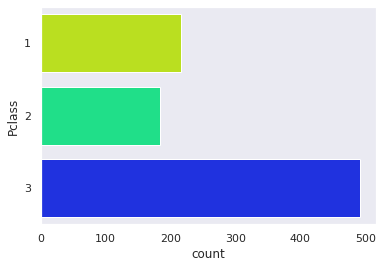

In [108]:
sns.set(style='dark')
ax=sns.countplot(y='Pclass' ,palette='gist_rainbow', data=df_train);

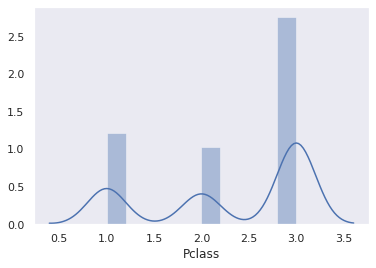

In [109]:
sns.distplot(df_train.Pclass)

In [110]:
df_bin["Pclass"]=df_train["Pclass"]
df_con["Pclass"]=df_train["Pclass"]  # #add data to our subset dataframes

### Name

In [111]:
df_train.Name.isnull().sum()


0

###  Sex / GENDER

In [112]:
df_train.Sex.isnull().sum()

0

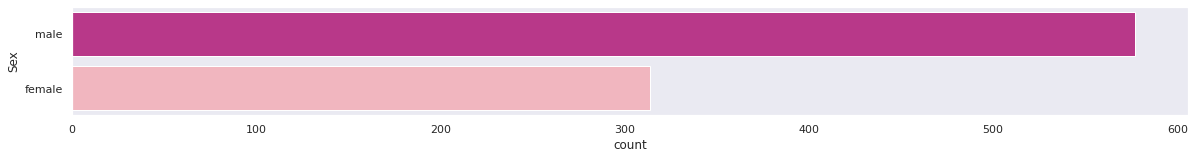

In [113]:
plt.figure(figsize=(20,2))
sns.countplot(y='Sex' , data=df_train , palette='RdPu_r')
sns.set(style="darkgrid")

In [114]:
df_bin['Sex'] = df_train['Sex']
df_bin['Sex'] = np.where(df_bin['Sex'] == 'female', 1, 0) # change sex to 0 for male and 1 for female

df_con['Sex'] = df_train['Sex']

### AGE

In [115]:
df_train.Age.isnull

<bound method Series.isnull of 0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888     NaN
889    26.0
890    32.0
Name: Age, Length: 891, dtype: float64>

In [116]:
ax=df_train.Age.isnull().sum() # total of age null value

In [117]:
total=df_train.Age.count()  # ototal of age with null and filled value

In [118]:
filled=total-ax
filled                    #diference between total of age - null value

537

#### GRPAH WITH NULL VALUE


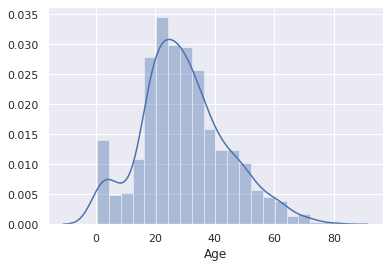

In [119]:
sns.distplot(df_train.Age)

### SibSp or Sibling 

In [40]:
df_train.SibSp.count()

891

In [41]:
df_train.SibSp.isnull().sum()

0

In [42]:
df_train.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

Text(0, 0.5, ' Average Children')

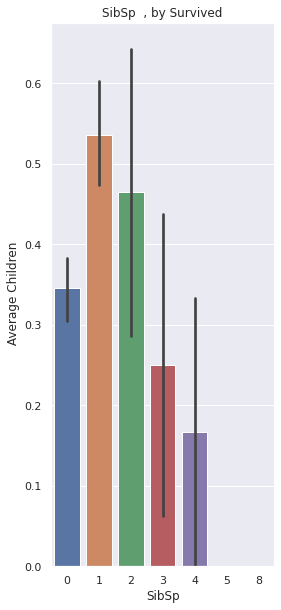

In [43]:
plt.figure(figsize=(4,10))

plt.title("SibSp  , by Survived")

sns.barplot(x=df_train.SibSp , y=df_train.Survived)

plt.ylabel(" Average Children")

In [44]:
df_bin['SibSp'] = df_train['SibSp']
df_con['SibSp'] = df_train['SibSp'] #add data to our subset dataframes

In [121]:

def plot_count_dist(data, bin_df, label_column, target_column, figsize=(20, 5), use_bin_df=False):
    """
    Function to plot counts and distributions of a label variable and 
    target variable side by side.
    ::param_data:: = target dataframe
    ::param_bin_df:: = binned dataframe for countplot
    ::param_label_column:: = binary labelled column
    ::param_target_column:: = column you want to view counts and distributions
    ::param_figsize:: = size of figure (width, height)
    ::param_use_bin_df:: = whether or not to use the bin_df, default False
    """
    if use_bin_df: 
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=bin_df);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});
    else:
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=data);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});

###  Parch**** 

In [46]:
df_train.Parch.isnull().sum()

0

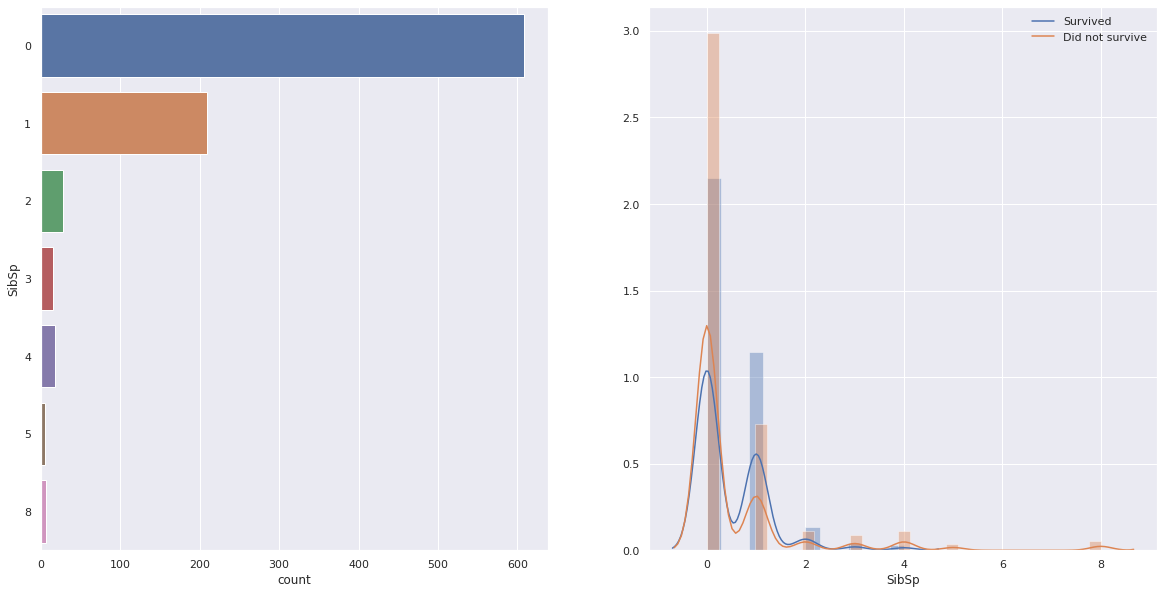

In [47]:
plot_count_dist(df_train, 
                bin_df=df_bin, 
                label_column='Survived', 
                target_column='SibSp', 
                figsize=(20, 10))

In [48]:
df_bin['Parch'] = df_train['Parch']
df_con['Parch'] = df_train['Parch']

#### FARE


In [49]:
df_train.Fare.isnull().sum()

0

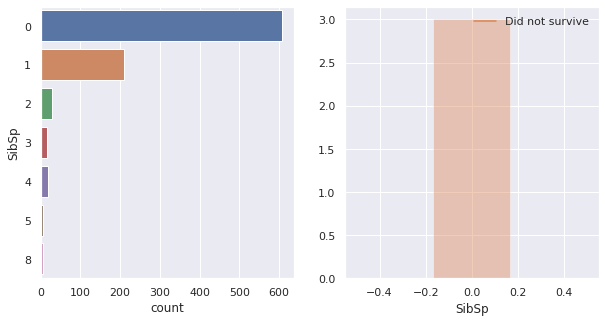

In [50]:
plot_count_dist(df_train, 
                bin_df=df_bin, 
                label_column='Fare', 
                target_column='SibSp', 
                figsize=(10, 5))

In [51]:
df_bin['Fare'] = df_train['Fare']
df_con['Fare'] = df_train['Fare']

###  Embarked

In [52]:
df_train.Embarked.isnull().sum()

2

In [53]:
df_bin['Embarked'] = df_train['Embarked']

df_con['Embarked'] = df_train['Embarked']

In [54]:
print(len(df_con))
df_con = df_con.dropna(subset=['Embarked'])
df_bin = df_bin.dropna(subset=['Embarked'])
print(len(df_con))

891
889


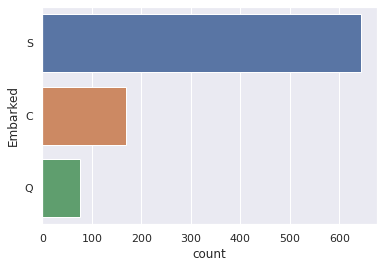

In [55]:
sns.countplot(y='Embarked', data=df_train);

# Machine Learning Models

# PREWORK

In [122]:
df_bin.head()

,Survived,Pclass,Sex
0,0,3,0
1,1,1,1
2,1,3,1
3,1,1,1
4,0,3,0


In [123]:
encode = df_bin.columns.tolist()
encode.remove('Survived')
df_binencode = pd.get_dummies(df_bin, columns=encode)

df_binencode.head()

,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1
0,0,0,0,1,1,0
1,1,1,0,0,0,1
2,1,0,0,1,0,1
3,1,1,0,0,0,1
4,0,0,0,1,1,0


In [124]:
df_con.head()

,Survived,Pclass,Sex
0,0,3,male
1,1,1,female
2,1,3,female
3,1,1,female
4,0,3,male


In [125]:
df_embarked_one_hot = pd.get_dummies(df_con['Embarked'], 
                                     prefix='embarked')

df_sex_one_hot = pd.get_dummies(df_con['Sex'], 
                                prefix='sex')

df_plcass_one_hot = pd.get_dummies(df_con['Pclass'], 
                                   prefix='pclass')

KeyError: 'Embarked'

In [60]:
df_con_enc = pd.concat([df_con, 
                        df_embarked_one_hot, 
                        df_sex_one_hot, 
                        df_plcass_one_hot], axis=1)

# Drop the original categorical columns (because now they've been one hot encoded)
df_con_enc = df_con_enc.drop(['Pclass', 'Sex', 'Embarked'], axis=1)

In [126]:
df_con_enc.tail()

,Survived,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
886,0,0,0,13.00,0,0,1,0,1,0,1,0
887,1,0,0,30.00,0,0,1,1,0,1,0,0
888,0,1,2,23.45,0,0,1,1,0,0,0,1
889,1,0,0,30.00,1,0,0,0,1,1,0,0
890,0,0,0,7.75,0,1,0,0,1,0,0,1


In [62]:
df_con_enc.describe()

,Survived,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,0.382452,0.524184,0.382452,32.096681,0.188976,0.086614,0.724409,0.350956,0.649044,0.240720,0.206974,0.552306
std,0.486260,1.103705,0.806761,49.697504,0.391710,0.281427,0.447063,0.477538,0.477538,0.427761,0.405365,0.497536
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,7.895800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,14.454200,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,0.000000,31.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [63]:
df_con_enc.count()

Survived      889
SibSp         889
Parch         889
Fare          889
embarked_C    889
embarked_Q    889
embarked_S    889
sex_female    889
sex_male      889
pclass_1      889
pclass_2      889
pclass_3      889
dtype: int64

In [64]:
df_con_enc

,Survived,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,0,8.0500,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,0,13.0000,0,0,1,0,1,0,1,0
887,1,0,0,30.0000,0,0,1,1,0,1,0,0
888,0,1,2,23.4500,0,0,1,1,0,0,0,1
889,1,0,0,30.0000,1,0,0,0,1,1,0,0


In [65]:
ML = df_con_enc

In [66]:
ML.shape

(889, 12)

In [67]:
ML

,Survived,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,0,8.0500,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,0,13.0000,0,0,1,0,1,0,1,0
887,1,0,0,30.0000,0,0,1,1,0,1,0,0
888,0,1,2,23.4500,0,0,1,1,0,0,0,1
889,1,0,0,30.0000,1,0,0,0,1,1,0,0


In [68]:
ML.tail()

,Survived,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
886,0,0,0,13.00,0,0,1,0,1,0,1,0
887,1,0,0,30.00,0,0,1,1,0,1,0,0
888,0,1,2,23.45,0,0,1,1,0,0,0,1
889,1,0,0,30.00,1,0,0,0,1,1,0,0
890,0,0,0,7.75,0,1,0,0,1,0,0,1


# TRAIN DATASETS

In [127]:
X_train=ML.drop("Survived" , axis=1)
y_train=ML.Survived

In [70]:
X_train.shape  ##ROW AND COLUMBS OF X_train

(889, 11)

In [71]:
y_train.shape  ## ROWS OF y_train/?

(889,)

In [128]:
def fit_ml_algo(algo, X_train, y_train, cv):
    
    # One Pass
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    # Cross Validation 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    # Cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv

# LOGESTIC REGRESSION

In [129]:
start=time.time()
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(),X_train,y_train,10)
log=(time.time()- start)
print("Accuracy:%s "  %acc_log)
print("Accuracy CV 10-Fold :%s" %acc_cv_log)
print("Running time:%s" %datetime.timedelta(seconds=log))

Accuracy:79.98 
Accuracy CV 10-Fold :79.42
Running time:0:00:00.285699


# Support Vector Machines (SVC)

In [131]:
start_time = time.time()
train_pred_svc, acc_linear_svc, acc_cv_linear_svc = fit_ml_algo(LinearSVC(),
                                                                X_train, 
                                                                y_train, 
                                                                10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

Accuracy: 78.97
Accuracy CV 10-Fold: 77.17
Running Time: 0:00:00.261733


# Decision Tree Classifier

In [145]:
import time

In [148]:
start_time = time.time()
train_pred_dt, acc_dt, acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(), 
                                                                X_train, 
                                                                y_train,
                                                                10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 92.46
Accuracy CV 10-Fold: 80.76
Running Time: 0:00:00.077466


# CatBoost 

In [150]:
X_train.head()

,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,0,71.2833,1,0,0,1,0,1,0,0
2,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,8.0500,0,0,1,0,1,0,0,1


In [151]:
X_train.tail()

,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
886,0,0,13.00,0,0,1,0,1,0,1,0
887,0,0,30.00,0,0,1,1,0,1,0,0
888,1,2,23.45,0,0,1,1,0,0,0,1
889,0,0,30.00,1,0,0,0,1,1,0,0
890,0,0,7.75,0,1,0,0,1,0,0,1


In [157]:
y_train.describe()

count    889.000000
mean       0.382452
std        0.486260
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

In [163]:
features=np.where(X_train.dtypes  != np.float)[0]
features

array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10])

In [165]:
pool_data=Pool(X_train ,  y_train , features)

In [182]:
Model=CatBoostClassifier(iterations=5000,custom_loss=['Accuracy'])

In [183]:
Model.fit(pool_data,plot=True)

Learning rate set to 0.00224
0:	learn: 0.6915681	total: 18.4ms	remaining: 1m 31s


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

1:	learn: 0.6903164	total: 27.1ms	remaining: 1m 7s
2:	learn: 0.6890185	total: 30.8ms	remaining: 51.3s
3:	learn: 0.6877931	total: 33.1ms	remaining: 41.4s
4:	learn: 0.6867983	total: 36ms	remaining: 36s
5:	learn: 0.6855996	total: 39ms	remaining: 32.4s
6:	learn: 0.6845938	total: 40.9ms	remaining: 29.2s
7:	learn: 0.6832797	total: 44ms	remaining: 27.5s
8:	learn: 0.6819059	total: 47.3ms	remaining: 26.2s
9:	learn: 0.6806991	total: 49.3ms	remaining: 24.6s
10:	learn: 0.6794250	total: 51ms	remaining: 23.2s
11:	learn: 0.6781195	total: 53.6ms	remaining: 22.3s
12:	learn: 0.6769309	total: 55.2ms	remaining: 21.2s
13:	learn: 0.6760997	total: 56.5ms	remaining: 20.1s
14:	learn: 0.6745749	total: 59.7ms	remaining: 19.8s
15:	learn: 0.6732773	total: 63ms	remaining: 19.6s
16:	learn: 0.6719204	total: 65.8ms	remaining: 19.3s
17:	learn: 0.6707060	total: 68.5ms	remaining: 19s
18:	learn: 0.6699310	total: 69.7ms	remaining: 18.3s
19:	learn: 0.6688593	total: 71.3ms	remaining: 17.7s
20:	learn: 0.6676224	total: 73.4ms	

174:	learn: 0.5381402	total: 392ms	remaining: 10.8s
175:	learn: 0.5373967	total: 394ms	remaining: 10.8s
176:	learn: 0.5369359	total: 397ms	remaining: 10.8s
177:	learn: 0.5362462	total: 399ms	remaining: 10.8s
178:	learn: 0.5356698	total: 402ms	remaining: 10.8s
179:	learn: 0.5352085	total: 403ms	remaining: 10.8s
180:	learn: 0.5348963	total: 404ms	remaining: 10.8s
181:	learn: 0.5344521	total: 406ms	remaining: 10.8s
182:	learn: 0.5339061	total: 409ms	remaining: 10.8s
183:	learn: 0.5333630	total: 411ms	remaining: 10.8s
184:	learn: 0.5330272	total: 412ms	remaining: 10.7s
185:	learn: 0.5324212	total: 414ms	remaining: 10.7s
186:	learn: 0.5318486	total: 416ms	remaining: 10.7s
187:	learn: 0.5313112	total: 418ms	remaining: 10.7s
188:	learn: 0.5307537	total: 421ms	remaining: 10.7s
189:	learn: 0.5303146	total: 422ms	remaining: 10.7s
190:	learn: 0.5296514	total: 424ms	remaining: 10.7s
191:	learn: 0.5291224	total: 426ms	remaining: 10.7s
192:	learn: 0.5285418	total: 429ms	remaining: 10.7s
193:	learn: 

356:	learn: 0.4712559	total: 772ms	remaining: 10s
357:	learn: 0.4710305	total: 774ms	remaining: 10s
358:	learn: 0.4707951	total: 776ms	remaining: 10s
359:	learn: 0.4705239	total: 779ms	remaining: 10s
360:	learn: 0.4702309	total: 782ms	remaining: 10s
361:	learn: 0.4698631	total: 786ms	remaining: 10.1s
362:	learn: 0.4697313	total: 787ms	remaining: 10.1s
363:	learn: 0.4693614	total: 790ms	remaining: 10.1s
364:	learn: 0.4691953	total: 792ms	remaining: 10.1s
365:	learn: 0.4689302	total: 794ms	remaining: 10.1s
366:	learn: 0.4688011	total: 795ms	remaining: 10s
367:	learn: 0.4684832	total: 797ms	remaining: 10s
368:	learn: 0.4683388	total: 799ms	remaining: 10s
369:	learn: 0.4682088	total: 800ms	remaining: 10s
370:	learn: 0.4678725	total: 802ms	remaining: 10s
371:	learn: 0.4676048	total: 804ms	remaining: 10s
372:	learn: 0.4674155	total: 806ms	remaining: 10s
373:	learn: 0.4670725	total: 808ms	remaining: 10s
374:	learn: 0.4667444	total: 811ms	remaining: 10s
375:	learn: 0.4665316	total: 812ms	remai

517:	learn: 0.4419873	total: 1.15s	remaining: 9.96s
518:	learn: 0.4418369	total: 1.16s	remaining: 9.98s
519:	learn: 0.4416326	total: 1.16s	remaining: 9.98s
520:	learn: 0.4414689	total: 1.16s	remaining: 9.98s
521:	learn: 0.4412323	total: 1.16s	remaining: 9.98s
522:	learn: 0.4411641	total: 1.17s	remaining: 9.98s
523:	learn: 0.4410484	total: 1.17s	remaining: 9.98s
524:	learn: 0.4409253	total: 1.17s	remaining: 9.98s
525:	learn: 0.4407401	total: 1.17s	remaining: 9.98s
526:	learn: 0.4406275	total: 1.18s	remaining: 9.98s
527:	learn: 0.4404894	total: 1.18s	remaining: 9.98s
528:	learn: 0.4403362	total: 1.18s	remaining: 9.98s
529:	learn: 0.4401299	total: 1.19s	remaining: 10s
530:	learn: 0.4400280	total: 1.19s	remaining: 10s
531:	learn: 0.4398506	total: 1.19s	remaining: 10s
532:	learn: 0.4396951	total: 1.19s	remaining: 10s
533:	learn: 0.4395437	total: 1.2s	remaining: 10s
534:	learn: 0.4394158	total: 1.2s	remaining: 10s
535:	learn: 0.4393027	total: 1.2s	remaining: 10s
536:	learn: 0.4391787	total: 

681:	learn: 0.4239824	total: 1.53s	remaining: 9.71s
682:	learn: 0.4239436	total: 1.54s	remaining: 9.71s
683:	learn: 0.4238486	total: 1.54s	remaining: 9.71s
684:	learn: 0.4238076	total: 1.54s	remaining: 9.71s
685:	learn: 0.4238021	total: 1.54s	remaining: 9.7s
686:	learn: 0.4236193	total: 1.54s	remaining: 9.7s
687:	learn: 0.4235574	total: 1.55s	remaining: 9.7s
688:	learn: 0.4235389	total: 1.55s	remaining: 9.69s
689:	learn: 0.4234111	total: 1.55s	remaining: 9.69s
690:	learn: 0.4233694	total: 1.55s	remaining: 9.69s
691:	learn: 0.4232989	total: 1.55s	remaining: 9.68s
692:	learn: 0.4232300	total: 1.56s	remaining: 9.68s
693:	learn: 0.4230940	total: 1.56s	remaining: 9.68s
694:	learn: 0.4230216	total: 1.56s	remaining: 9.68s
695:	learn: 0.4229541	total: 1.56s	remaining: 9.68s
696:	learn: 0.4228048	total: 1.57s	remaining: 9.7s
697:	learn: 0.4227123	total: 1.57s	remaining: 9.7s
698:	learn: 0.4226603	total: 1.57s	remaining: 9.7s
699:	learn: 0.4225905	total: 1.58s	remaining: 9.7s
700:	learn: 0.42249

852:	learn: 0.4128742	total: 1.92s	remaining: 9.35s
853:	learn: 0.4127482	total: 1.93s	remaining: 9.35s
854:	learn: 0.4126857	total: 1.93s	remaining: 9.35s
855:	learn: 0.4126123	total: 1.98s	remaining: 9.59s
856:	learn: 0.4125063	total: 1.98s	remaining: 9.59s
857:	learn: 0.4124114	total: 1.99s	remaining: 9.6s
858:	learn: 0.4123615	total: 1.99s	remaining: 9.6s
859:	learn: 0.4123166	total: 1.99s	remaining: 9.6s
860:	learn: 0.4122233	total: 2s	remaining: 9.6s
861:	learn: 0.4121380	total: 2s	remaining: 9.6s
862:	learn: 0.4120512	total: 2s	remaining: 9.6s
863:	learn: 0.4119449	total: 2s	remaining: 9.6s
864:	learn: 0.4119426	total: 2.01s	remaining: 9.59s
865:	learn: 0.4119074	total: 2.01s	remaining: 9.59s
866:	learn: 0.4118922	total: 2.01s	remaining: 9.59s
867:	learn: 0.4118810	total: 2.01s	remaining: 9.58s
868:	learn: 0.4118398	total: 2.02s	remaining: 9.58s
869:	learn: 0.4117814	total: 2.02s	remaining: 9.59s
870:	learn: 0.4117327	total: 2.02s	remaining: 9.59s
871:	learn: 0.4116654	total: 2.

1070:	learn: 0.4028462	total: 2.5s	remaining: 9.15s
1071:	learn: 0.4027573	total: 2.5s	remaining: 9.16s
1072:	learn: 0.4027489	total: 2.5s	remaining: 9.15s
1073:	learn: 0.4026947	total: 2.5s	remaining: 9.15s
1074:	learn: 0.4026290	total: 2.51s	remaining: 9.15s
1075:	learn: 0.4026233	total: 2.51s	remaining: 9.14s
1076:	learn: 0.4026000	total: 2.51s	remaining: 9.14s
1077:	learn: 0.4025846	total: 2.51s	remaining: 9.14s
1078:	learn: 0.4025220	total: 2.52s	remaining: 9.14s
1079:	learn: 0.4024705	total: 2.52s	remaining: 9.14s
1080:	learn: 0.4024696	total: 2.52s	remaining: 9.13s
1081:	learn: 0.4024251	total: 2.52s	remaining: 9.13s
1082:	learn: 0.4024243	total: 2.52s	remaining: 9.12s
1083:	learn: 0.4023526	total: 2.52s	remaining: 9.12s
1084:	learn: 0.4023195	total: 2.53s	remaining: 9.12s
1085:	learn: 0.4022823	total: 2.53s	remaining: 9.11s
1086:	learn: 0.4022459	total: 2.53s	remaining: 9.11s
1087:	learn: 0.4022180	total: 2.53s	remaining: 9.11s
1088:	learn: 0.4022172	total: 2.53s	remaining: 9.1

1242:	learn: 0.3972794	total: 2.87s	remaining: 8.69s
1243:	learn: 0.3972519	total: 2.88s	remaining: 8.69s
1244:	learn: 0.3972483	total: 2.88s	remaining: 8.68s
1245:	learn: 0.3971731	total: 2.88s	remaining: 8.68s
1246:	learn: 0.3971725	total: 2.88s	remaining: 8.68s
1247:	learn: 0.3971635	total: 2.88s	remaining: 8.67s
1248:	learn: 0.3971007	total: 2.89s	remaining: 8.67s
1249:	learn: 0.3970895	total: 2.89s	remaining: 8.67s
1250:	learn: 0.3970529	total: 2.89s	remaining: 8.67s
1251:	learn: 0.3969737	total: 2.89s	remaining: 8.66s
1252:	learn: 0.3969467	total: 2.9s	remaining: 8.66s
1253:	learn: 0.3969445	total: 2.9s	remaining: 8.66s
1254:	learn: 0.3969441	total: 2.9s	remaining: 8.65s
1255:	learn: 0.3968241	total: 2.9s	remaining: 8.65s
1256:	learn: 0.3968070	total: 2.9s	remaining: 8.64s
1257:	learn: 0.3967595	total: 2.9s	remaining: 8.64s
1258:	learn: 0.3967193	total: 2.91s	remaining: 8.64s
1259:	learn: 0.3967124	total: 2.91s	remaining: 8.63s
1260:	learn: 0.3966980	total: 2.91s	remaining: 8.63s

1445:	learn: 0.3917643	total: 3.37s	remaining: 8.28s
1446:	learn: 0.3917366	total: 3.37s	remaining: 8.28s
1447:	learn: 0.3917093	total: 3.37s	remaining: 8.28s
1448:	learn: 0.3917063	total: 3.38s	remaining: 8.27s
1449:	learn: 0.3916471	total: 3.38s	remaining: 8.27s
1450:	learn: 0.3916292	total: 3.38s	remaining: 8.27s
1451:	learn: 0.3916215	total: 3.38s	remaining: 8.27s
1452:	learn: 0.3916210	total: 3.38s	remaining: 8.26s
1453:	learn: 0.3915613	total: 3.39s	remaining: 8.26s
1454:	learn: 0.3915217	total: 3.39s	remaining: 8.26s
1455:	learn: 0.3914741	total: 3.39s	remaining: 8.25s
1456:	learn: 0.3914146	total: 3.39s	remaining: 8.25s
1457:	learn: 0.3913970	total: 3.4s	remaining: 8.25s
1458:	learn: 0.3913570	total: 3.4s	remaining: 8.25s
1459:	learn: 0.3913124	total: 3.4s	remaining: 8.24s
1460:	learn: 0.3912953	total: 3.4s	remaining: 8.24s
1461:	learn: 0.3912904	total: 3.4s	remaining: 8.24s
1462:	learn: 0.3912183	total: 3.41s	remaining: 8.24s
1463:	learn: 0.3911885	total: 3.41s	remaining: 8.23

1620:	learn: 0.3875591	total: 3.75s	remaining: 7.82s
1621:	learn: 0.3875562	total: 3.75s	remaining: 7.82s
1622:	learn: 0.3875374	total: 3.76s	remaining: 7.82s
1623:	learn: 0.3875224	total: 3.76s	remaining: 7.82s
1624:	learn: 0.3874773	total: 3.76s	remaining: 7.82s
1625:	learn: 0.3874478	total: 3.77s	remaining: 7.82s
1626:	learn: 0.3874359	total: 3.77s	remaining: 7.81s
1627:	learn: 0.3873973	total: 3.77s	remaining: 7.81s
1628:	learn: 0.3873404	total: 3.77s	remaining: 7.81s
1629:	learn: 0.3873396	total: 3.78s	remaining: 7.81s
1630:	learn: 0.3872803	total: 3.78s	remaining: 7.81s
1631:	learn: 0.3872381	total: 3.78s	remaining: 7.8s
1632:	learn: 0.3872226	total: 3.78s	remaining: 7.8s
1633:	learn: 0.3872046	total: 3.79s	remaining: 7.8s
1634:	learn: 0.3871998	total: 3.79s	remaining: 7.8s
1635:	learn: 0.3871708	total: 3.79s	remaining: 7.79s
1636:	learn: 0.3871577	total: 3.79s	remaining: 7.79s
1637:	learn: 0.3871320	total: 3.8s	remaining: 7.79s
1638:	learn: 0.3871276	total: 3.8s	remaining: 7.79s

1780:	learn: 0.3843176	total: 4.21s	remaining: 7.6s
1781:	learn: 0.3843075	total: 4.21s	remaining: 7.61s
1782:	learn: 0.3843075	total: 4.21s	remaining: 7.6s
1783:	learn: 0.3843020	total: 4.21s	remaining: 7.6s
1784:	learn: 0.3842920	total: 4.22s	remaining: 7.6s
1785:	learn: 0.3842320	total: 4.22s	remaining: 7.59s
1786:	learn: 0.3842062	total: 4.22s	remaining: 7.59s
1787:	learn: 0.3842029	total: 4.22s	remaining: 7.59s
1788:	learn: 0.3841938	total: 4.23s	remaining: 7.59s
1789:	learn: 0.3841857	total: 4.23s	remaining: 7.58s
1790:	learn: 0.3841476	total: 4.23s	remaining: 7.58s
1791:	learn: 0.3841395	total: 4.23s	remaining: 7.58s
1792:	learn: 0.3841252	total: 4.24s	remaining: 7.58s
1793:	learn: 0.3841153	total: 4.24s	remaining: 7.57s
1794:	learn: 0.3840800	total: 4.24s	remaining: 7.57s
1795:	learn: 0.3840685	total: 4.24s	remaining: 7.57s
1796:	learn: 0.3840369	total: 4.25s	remaining: 7.57s
1797:	learn: 0.3840205	total: 4.25s	remaining: 7.57s
1798:	learn: 0.3840120	total: 4.25s	remaining: 7.5

1951:	learn: 0.3807702	total: 4.59s	remaining: 7.16s
1952:	learn: 0.3807637	total: 4.59s	remaining: 7.16s
1953:	learn: 0.3807538	total: 4.59s	remaining: 7.16s
1954:	learn: 0.3807096	total: 4.6s	remaining: 7.16s
1955:	learn: 0.3806871	total: 4.6s	remaining: 7.16s
1956:	learn: 0.3806773	total: 4.6s	remaining: 7.16s
1957:	learn: 0.3806404	total: 4.6s	remaining: 7.15s
1958:	learn: 0.3806070	total: 4.61s	remaining: 7.15s
1959:	learn: 0.3806070	total: 4.61s	remaining: 7.15s
1960:	learn: 0.3805512	total: 4.61s	remaining: 7.14s
1961:	learn: 0.3805352	total: 4.61s	remaining: 7.14s
1962:	learn: 0.3804843	total: 4.62s	remaining: 7.14s
1963:	learn: 0.3804775	total: 4.62s	remaining: 7.14s
1964:	learn: 0.3804676	total: 4.62s	remaining: 7.13s
1965:	learn: 0.3804598	total: 4.62s	remaining: 7.13s
1966:	learn: 0.3804598	total: 4.62s	remaining: 7.13s
1967:	learn: 0.3804513	total: 4.63s	remaining: 7.13s
1968:	learn: 0.3804241	total: 4.63s	remaining: 7.12s
1969:	learn: 0.3803961	total: 4.63s	remaining: 7.1

2122:	learn: 0.3774542	total: 4.99s	remaining: 6.76s
2123:	learn: 0.3774180	total: 5.07s	remaining: 6.86s
2124:	learn: 0.3774040	total: 5.07s	remaining: 6.86s
2125:	learn: 0.3773851	total: 5.07s	remaining: 6.86s
2126:	learn: 0.3773760	total: 5.08s	remaining: 6.86s
2127:	learn: 0.3773760	total: 5.08s	remaining: 6.85s
2128:	learn: 0.3773702	total: 5.08s	remaining: 6.85s
2129:	learn: 0.3773068	total: 5.08s	remaining: 6.85s
2130:	learn: 0.3773016	total: 5.09s	remaining: 6.85s
2131:	learn: 0.3772828	total: 5.09s	remaining: 6.84s
2132:	learn: 0.3772786	total: 5.09s	remaining: 6.84s
2133:	learn: 0.3772715	total: 5.09s	remaining: 6.84s
2134:	learn: 0.3772560	total: 5.1s	remaining: 6.84s
2135:	learn: 0.3772454	total: 5.1s	remaining: 6.84s
2136:	learn: 0.3771818	total: 5.1s	remaining: 6.84s
2137:	learn: 0.3771799	total: 5.1s	remaining: 6.83s
2138:	learn: 0.3771637	total: 5.11s	remaining: 6.83s
2139:	learn: 0.3771496	total: 5.11s	remaining: 6.83s
2140:	learn: 0.3771119	total: 5.11s	remaining: 6.8

2347:	learn: 0.3735760	total: 5.57s	remaining: 6.29s
2348:	learn: 0.3735369	total: 5.57s	remaining: 6.29s
2349:	learn: 0.3735369	total: 5.58s	remaining: 6.29s
2350:	learn: 0.3735291	total: 5.58s	remaining: 6.28s
2351:	learn: 0.3734911	total: 5.58s	remaining: 6.28s
2352:	learn: 0.3734799	total: 5.58s	remaining: 6.28s
2353:	learn: 0.3734778	total: 5.58s	remaining: 6.28s
2354:	learn: 0.3734637	total: 5.59s	remaining: 6.27s
2355:	learn: 0.3734522	total: 5.59s	remaining: 6.27s
2356:	learn: 0.3734264	total: 5.59s	remaining: 6.27s
2357:	learn: 0.3734007	total: 5.59s	remaining: 6.27s
2358:	learn: 0.3733595	total: 5.59s	remaining: 6.26s
2359:	learn: 0.3733246	total: 5.6s	remaining: 6.26s
2360:	learn: 0.3732528	total: 5.6s	remaining: 6.26s
2361:	learn: 0.3732484	total: 5.6s	remaining: 6.26s
2362:	learn: 0.3732423	total: 5.6s	remaining: 6.25s
2363:	learn: 0.3732423	total: 5.61s	remaining: 6.25s
2364:	learn: 0.3731873	total: 5.61s	remaining: 6.25s
2365:	learn: 0.3731773	total: 5.61s	remaining: 6.2

2525:	learn: 0.3705142	total: 5.95s	remaining: 5.83s
2526:	learn: 0.3704966	total: 5.95s	remaining: 5.83s
2527:	learn: 0.3704966	total: 5.95s	remaining: 5.82s
2528:	learn: 0.3704794	total: 5.96s	remaining: 5.82s
2529:	learn: 0.3704756	total: 5.96s	remaining: 5.82s
2530:	learn: 0.3704691	total: 5.96s	remaining: 5.82s
2531:	learn: 0.3704409	total: 5.96s	remaining: 5.81s
2532:	learn: 0.3704153	total: 5.97s	remaining: 5.81s
2533:	learn: 0.3704013	total: 5.97s	remaining: 5.81s
2534:	learn: 0.3704012	total: 5.97s	remaining: 5.8s
2535:	learn: 0.3703960	total: 5.97s	remaining: 5.8s
2536:	learn: 0.3703849	total: 5.97s	remaining: 5.8s
2537:	learn: 0.3703712	total: 5.98s	remaining: 5.8s
2538:	learn: 0.3703532	total: 5.98s	remaining: 5.79s
2539:	learn: 0.3703387	total: 5.98s	remaining: 5.79s
2540:	learn: 0.3703173	total: 5.98s	remaining: 5.79s
2541:	learn: 0.3702756	total: 5.99s	remaining: 5.79s
2542:	learn: 0.3702665	total: 5.99s	remaining: 5.79s
2543:	learn: 0.3702546	total: 5.99s	remaining: 5.7

2705:	learn: 0.3670754	total: 6.66s	remaining: 5.64s
2706:	learn: 0.3670723	total: 6.66s	remaining: 5.64s
2707:	learn: 0.3670561	total: 6.66s	remaining: 5.64s
2708:	learn: 0.3670302	total: 6.66s	remaining: 5.63s
2709:	learn: 0.3670068	total: 6.67s	remaining: 5.63s
2710:	learn: 0.3670064	total: 6.67s	remaining: 5.63s
2711:	learn: 0.3669954	total: 6.67s	remaining: 5.63s
2712:	learn: 0.3669825	total: 6.67s	remaining: 5.62s
2713:	learn: 0.3669785	total: 6.67s	remaining: 5.62s
2714:	learn: 0.3669782	total: 6.67s	remaining: 5.62s
2715:	learn: 0.3669684	total: 6.68s	remaining: 5.61s
2716:	learn: 0.3669591	total: 6.68s	remaining: 5.61s
2717:	learn: 0.3669512	total: 6.68s	remaining: 5.61s
2718:	learn: 0.3668968	total: 6.68s	remaining: 5.61s
2719:	learn: 0.3668703	total: 6.69s	remaining: 5.6s
2720:	learn: 0.3668643	total: 6.69s	remaining: 5.6s
2721:	learn: 0.3668407	total: 6.69s	remaining: 5.6s
2722:	learn: 0.3668258	total: 6.69s	remaining: 5.6s
2723:	learn: 0.3668038	total: 6.69s	remaining: 5.5

2877:	learn: 0.3643812	total: 7.04s	remaining: 5.19s
2878:	learn: 0.3643359	total: 7.04s	remaining: 5.19s
2879:	learn: 0.3643226	total: 7.04s	remaining: 5.18s
2880:	learn: 0.3643190	total: 7.04s	remaining: 5.18s
2881:	learn: 0.3643079	total: 7.05s	remaining: 5.18s
2882:	learn: 0.3643079	total: 7.05s	remaining: 5.17s
2883:	learn: 0.3642972	total: 7.05s	remaining: 5.17s
2884:	learn: 0.3642834	total: 7.05s	remaining: 5.17s
2885:	learn: 0.3642723	total: 7.05s	remaining: 5.17s
2886:	learn: 0.3642271	total: 7.06s	remaining: 5.17s
2887:	learn: 0.3642244	total: 7.06s	remaining: 5.16s
2888:	learn: 0.3641839	total: 7.06s	remaining: 5.16s
2889:	learn: 0.3641706	total: 7.06s	remaining: 5.16s
2890:	learn: 0.3641638	total: 7.07s	remaining: 5.15s
2891:	learn: 0.3641602	total: 7.07s	remaining: 5.15s
2892:	learn: 0.3641418	total: 7.07s	remaining: 5.15s
2893:	learn: 0.3641204	total: 7.07s	remaining: 5.15s
2894:	learn: 0.3641060	total: 7.08s	remaining: 5.14s
2895:	learn: 0.3640734	total: 7.08s	remaining:

3072:	learn: 0.3612985	total: 7.66s	remaining: 4.8s
3073:	learn: 0.3612924	total: 7.66s	remaining: 4.8s
3074:	learn: 0.3612811	total: 7.66s	remaining: 4.8s
3075:	learn: 0.3612666	total: 7.66s	remaining: 4.79s
3076:	learn: 0.3612545	total: 7.67s	remaining: 4.79s
3077:	learn: 0.3612500	total: 7.67s	remaining: 4.79s
3078:	learn: 0.3612198	total: 7.67s	remaining: 4.79s
3079:	learn: 0.3611941	total: 7.67s	remaining: 4.78s
3080:	learn: 0.3611928	total: 7.68s	remaining: 4.78s
3081:	learn: 0.3611647	total: 7.68s	remaining: 4.78s
3082:	learn: 0.3611405	total: 7.68s	remaining: 4.78s
3083:	learn: 0.3611087	total: 7.68s	remaining: 4.77s
3084:	learn: 0.3610984	total: 7.69s	remaining: 4.77s
3085:	learn: 0.3610941	total: 7.69s	remaining: 4.77s
3086:	learn: 0.3610795	total: 7.69s	remaining: 4.77s
3087:	learn: 0.3610768	total: 7.69s	remaining: 4.76s
3088:	learn: 0.3610674	total: 7.69s	remaining: 4.76s
3089:	learn: 0.3610673	total: 7.7s	remaining: 4.76s
3090:	learn: 0.3610365	total: 7.7s	remaining: 4.75

3240:	learn: 0.3583626	total: 8.04s	remaining: 4.36s
3241:	learn: 0.3583217	total: 8.04s	remaining: 4.36s
3242:	learn: 0.3582960	total: 8.04s	remaining: 4.36s
3243:	learn: 0.3582730	total: 8.05s	remaining: 4.36s
3244:	learn: 0.3582278	total: 8.05s	remaining: 4.35s
3245:	learn: 0.3582136	total: 8.05s	remaining: 4.35s
3246:	learn: 0.3582104	total: 8.05s	remaining: 4.35s
3247:	learn: 0.3582077	total: 8.06s	remaining: 4.34s
3248:	learn: 0.3581873	total: 8.06s	remaining: 4.34s
3249:	learn: 0.3581655	total: 8.06s	remaining: 4.34s
3250:	learn: 0.3581636	total: 8.06s	remaining: 4.34s
3251:	learn: 0.3581536	total: 8.06s	remaining: 4.33s
3252:	learn: 0.3581422	total: 8.07s	remaining: 4.33s
3253:	learn: 0.3581246	total: 8.07s	remaining: 4.33s
3254:	learn: 0.3581201	total: 8.07s	remaining: 4.33s
3255:	learn: 0.3581138	total: 8.07s	remaining: 4.33s
3256:	learn: 0.3580874	total: 8.08s	remaining: 4.32s
3257:	learn: 0.3580874	total: 8.08s	remaining: 4.32s
3258:	learn: 0.3580825	total: 8.08s	remaining:

3397:	learn: 0.3558895	total: 8.61s	remaining: 4.06s
3398:	learn: 0.3558643	total: 8.61s	remaining: 4.05s
3399:	learn: 0.3558457	total: 8.61s	remaining: 4.05s
3400:	learn: 0.3558299	total: 8.61s	remaining: 4.05s
3401:	learn: 0.3558299	total: 8.62s	remaining: 4.05s
3402:	learn: 0.3558237	total: 8.62s	remaining: 4.04s
3403:	learn: 0.3558154	total: 8.62s	remaining: 4.04s
3404:	learn: 0.3558003	total: 8.62s	remaining: 4.04s
3405:	learn: 0.3557969	total: 8.62s	remaining: 4.04s
3406:	learn: 0.3557901	total: 8.63s	remaining: 4.03s
3407:	learn: 0.3557817	total: 8.63s	remaining: 4.03s
3408:	learn: 0.3557801	total: 8.63s	remaining: 4.03s
3409:	learn: 0.3557495	total: 8.63s	remaining: 4.03s
3410:	learn: 0.3557176	total: 8.64s	remaining: 4.02s
3411:	learn: 0.3557137	total: 8.64s	remaining: 4.02s
3412:	learn: 0.3557123	total: 8.64s	remaining: 4.02s
3413:	learn: 0.3556979	total: 8.64s	remaining: 4.01s
3414:	learn: 0.3556761	total: 8.64s	remaining: 4.01s
3415:	learn: 0.3556471	total: 8.65s	remaining:

3557:	learn: 0.3534228	total: 8.98s	remaining: 3.64s
3558:	learn: 0.3534037	total: 8.99s	remaining: 3.64s
3559:	learn: 0.3533891	total: 8.99s	remaining: 3.64s
3560:	learn: 0.3533709	total: 9s	remaining: 3.63s
3561:	learn: 0.3533547	total: 9s	remaining: 3.63s
3562:	learn: 0.3533398	total: 9s	remaining: 3.63s
3563:	learn: 0.3533371	total: 9s	remaining: 3.63s
3564:	learn: 0.3532942	total: 9.01s	remaining: 3.63s
3565:	learn: 0.3532925	total: 9.01s	remaining: 3.62s
3566:	learn: 0.3532907	total: 9.01s	remaining: 3.62s
3567:	learn: 0.3532874	total: 9.01s	remaining: 3.62s
3568:	learn: 0.3532874	total: 9.01s	remaining: 3.61s
3569:	learn: 0.3532552	total: 9.01s	remaining: 3.61s
3570:	learn: 0.3532498	total: 9.02s	remaining: 3.61s
3571:	learn: 0.3532231	total: 9.02s	remaining: 3.6s
3572:	learn: 0.3532131	total: 9.02s	remaining: 3.6s
3573:	learn: 0.3531978	total: 9.02s	remaining: 3.6s
3574:	learn: 0.3531942	total: 9.03s	remaining: 3.6s
3575:	learn: 0.3531729	total: 9.03s	remaining: 3.6s
3576:	lear

3720:	learn: 0.3507654	total: 9.38s	remaining: 3.22s
3721:	learn: 0.3507517	total: 9.38s	remaining: 3.22s
3722:	learn: 0.3507176	total: 9.43s	remaining: 3.23s
3723:	learn: 0.3507095	total: 9.53s	remaining: 3.26s
3724:	learn: 0.3506982	total: 9.58s	remaining: 3.28s
3725:	learn: 0.3506865	total: 9.59s	remaining: 3.28s
3726:	learn: 0.3506662	total: 9.59s	remaining: 3.27s
3727:	learn: 0.3506589	total: 9.59s	remaining: 3.27s
3728:	learn: 0.3506469	total: 9.59s	remaining: 3.27s
3729:	learn: 0.3506367	total: 9.6s	remaining: 3.27s
3730:	learn: 0.3506032	total: 9.6s	remaining: 3.27s
3731:	learn: 0.3505876	total: 9.6s	remaining: 3.26s
3732:	learn: 0.3505870	total: 9.61s	remaining: 3.26s
3733:	learn: 0.3505626	total: 9.61s	remaining: 3.26s
3734:	learn: 0.3505323	total: 9.61s	remaining: 3.25s
3735:	learn: 0.3505084	total: 9.62s	remaining: 3.25s
3736:	learn: 0.3504897	total: 9.62s	remaining: 3.25s
3737:	learn: 0.3504756	total: 9.62s	remaining: 3.25s
3738:	learn: 0.3504657	total: 9.63s	remaining: 3.

3947:	learn: 0.3472805	total: 10.2s	remaining: 2.71s
3948:	learn: 0.3472680	total: 10.2s	remaining: 2.71s
3949:	learn: 0.3472398	total: 10.2s	remaining: 2.7s
3950:	learn: 0.3472337	total: 10.2s	remaining: 2.7s
3951:	learn: 0.3472040	total: 10.2s	remaining: 2.7s
3952:	learn: 0.3471618	total: 10.2s	remaining: 2.69s
3953:	learn: 0.3471402	total: 10.2s	remaining: 2.69s
3954:	learn: 0.3471256	total: 10.2s	remaining: 2.69s
3955:	learn: 0.3471215	total: 10.2s	remaining: 2.69s
3956:	learn: 0.3471105	total: 10.2s	remaining: 2.68s
3957:	learn: 0.3470858	total: 10.2s	remaining: 2.68s
3958:	learn: 0.3470798	total: 10.2s	remaining: 2.68s
3959:	learn: 0.3470660	total: 10.2s	remaining: 2.68s
3960:	learn: 0.3470556	total: 10.2s	remaining: 2.67s
3961:	learn: 0.3470258	total: 10.2s	remaining: 2.67s
3962:	learn: 0.3469842	total: 10.2s	remaining: 2.67s
3963:	learn: 0.3469732	total: 10.2s	remaining: 2.67s
3964:	learn: 0.3469644	total: 10.2s	remaining: 2.67s
3965:	learn: 0.3469536	total: 10.2s	remaining: 2.

4135:	learn: 0.3439923	total: 11s	remaining: 2.29s
4136:	learn: 0.3439636	total: 11s	remaining: 2.29s
4137:	learn: 0.3439581	total: 11s	remaining: 2.29s
4138:	learn: 0.3439532	total: 11s	remaining: 2.28s
4139:	learn: 0.3439105	total: 11s	remaining: 2.28s
4140:	learn: 0.3438711	total: 11s	remaining: 2.28s
4141:	learn: 0.3438508	total: 11s	remaining: 2.27s
4142:	learn: 0.3438373	total: 11s	remaining: 2.27s
4143:	learn: 0.3438321	total: 11s	remaining: 2.27s
4144:	learn: 0.3438059	total: 11s	remaining: 2.27s
4145:	learn: 0.3437952	total: 11s	remaining: 2.26s
4146:	learn: 0.3437871	total: 11s	remaining: 2.26s
4147:	learn: 0.3437781	total: 11s	remaining: 2.26s
4148:	learn: 0.3437593	total: 11s	remaining: 2.26s
4149:	learn: 0.3437527	total: 11s	remaining: 2.25s
4150:	learn: 0.3437403	total: 11s	remaining: 2.25s
4151:	learn: 0.3437172	total: 11s	remaining: 2.25s
4152:	learn: 0.3436865	total: 11s	remaining: 2.25s
4153:	learn: 0.3436682	total: 11s	remaining: 2.24s
4154:	learn: 0.3436660	total: 1

4292:	learn: 0.3411813	total: 11.4s	remaining: 1.87s
4293:	learn: 0.3411645	total: 11.4s	remaining: 1.87s
4294:	learn: 0.3411186	total: 11.4s	remaining: 1.86s
4295:	learn: 0.3410922	total: 11.4s	remaining: 1.86s
4296:	learn: 0.3410807	total: 11.4s	remaining: 1.86s
4297:	learn: 0.3410484	total: 11.4s	remaining: 1.86s
4298:	learn: 0.3410343	total: 11.4s	remaining: 1.85s
4299:	learn: 0.3410138	total: 11.4s	remaining: 1.85s
4300:	learn: 0.3410023	total: 11.4s	remaining: 1.85s
4301:	learn: 0.3409434	total: 11.4s	remaining: 1.85s
4302:	learn: 0.3409098	total: 11.4s	remaining: 1.84s
4303:	learn: 0.3408869	total: 11.4s	remaining: 1.84s
4304:	learn: 0.3408611	total: 11.4s	remaining: 1.84s
4305:	learn: 0.3408542	total: 11.4s	remaining: 1.83s
4306:	learn: 0.3408314	total: 11.4s	remaining: 1.83s
4307:	learn: 0.3408148	total: 11.4s	remaining: 1.83s
4308:	learn: 0.3407961	total: 11.4s	remaining: 1.83s
4309:	learn: 0.3407712	total: 11.4s	remaining: 1.82s
4310:	learn: 0.3407602	total: 11.4s	remaining:

4500:	learn: 0.3372691	total: 12.2s	remaining: 1.35s
4501:	learn: 0.3372578	total: 12.2s	remaining: 1.35s
4502:	learn: 0.3372505	total: 12.2s	remaining: 1.35s
4503:	learn: 0.3372348	total: 12.2s	remaining: 1.35s
4504:	learn: 0.3372065	total: 12.2s	remaining: 1.34s
4505:	learn: 0.3372013	total: 12.2s	remaining: 1.34s
4506:	learn: 0.3371902	total: 12.2s	remaining: 1.34s
4507:	learn: 0.3371803	total: 12.2s	remaining: 1.33s
4508:	learn: 0.3371602	total: 12.2s	remaining: 1.33s
4509:	learn: 0.3371184	total: 12.2s	remaining: 1.33s
4510:	learn: 0.3370999	total: 12.2s	remaining: 1.33s
4511:	learn: 0.3370771	total: 12.2s	remaining: 1.32s
4512:	learn: 0.3370705	total: 12.2s	remaining: 1.32s
4513:	learn: 0.3370488	total: 12.2s	remaining: 1.32s
4514:	learn: 0.3370299	total: 12.3s	remaining: 1.32s
4515:	learn: 0.3370073	total: 12.3s	remaining: 1.31s
4516:	learn: 0.3369956	total: 12.3s	remaining: 1.31s
4517:	learn: 0.3369905	total: 12.3s	remaining: 1.31s
4518:	learn: 0.3369557	total: 12.3s	remaining:

4657:	learn: 0.3343669	total: 12.6s	remaining: 925ms
4658:	learn: 0.3343312	total: 12.6s	remaining: 922ms
4659:	learn: 0.3342933	total: 12.6s	remaining: 920ms
4660:	learn: 0.3342871	total: 12.6s	remaining: 917ms
4661:	learn: 0.3342719	total: 12.6s	remaining: 914ms
4662:	learn: 0.3342496	total: 12.6s	remaining: 911ms
4663:	learn: 0.3342272	total: 12.6s	remaining: 909ms
4664:	learn: 0.3342163	total: 12.6s	remaining: 906ms
4665:	learn: 0.3342115	total: 12.6s	remaining: 903ms
4666:	learn: 0.3341893	total: 12.6s	remaining: 900ms
4667:	learn: 0.3341750	total: 12.6s	remaining: 898ms
4668:	learn: 0.3341582	total: 12.6s	remaining: 895ms
4669:	learn: 0.3341393	total: 12.6s	remaining: 892ms
4670:	learn: 0.3341289	total: 12.6s	remaining: 890ms
4671:	learn: 0.3340949	total: 12.6s	remaining: 887ms
4672:	learn: 0.3340819	total: 12.6s	remaining: 884ms
4673:	learn: 0.3340724	total: 12.6s	remaining: 881ms
4674:	learn: 0.3340585	total: 12.6s	remaining: 879ms
4675:	learn: 0.3340405	total: 12.6s	remaining:

4812:	learn: 0.3310848	total: 13.1s	remaining: 507ms
4813:	learn: 0.3310443	total: 13.2s	remaining: 508ms
4814:	learn: 0.3310343	total: 13.2s	remaining: 507ms
4815:	learn: 0.3310085	total: 13.2s	remaining: 504ms
4816:	learn: 0.3309850	total: 13.2s	remaining: 502ms
4817:	learn: 0.3309677	total: 13.2s	remaining: 499ms
4818:	learn: 0.3309555	total: 13.2s	remaining: 496ms
4819:	learn: 0.3309449	total: 13.2s	remaining: 494ms
4820:	learn: 0.3308996	total: 13.2s	remaining: 491ms
4821:	learn: 0.3308891	total: 13.2s	remaining: 488ms
4822:	learn: 0.3308646	total: 13.2s	remaining: 485ms
4823:	learn: 0.3308230	total: 13.2s	remaining: 483ms
4824:	learn: 0.3308140	total: 13.2s	remaining: 480ms
4825:	learn: 0.3307959	total: 13.2s	remaining: 477ms
4826:	learn: 0.3307493	total: 13.2s	remaining: 474ms
4827:	learn: 0.3307395	total: 13.2s	remaining: 472ms
4828:	learn: 0.3307262	total: 13.2s	remaining: 469ms
4829:	learn: 0.3307053	total: 13.3s	remaining: 466ms
4830:	learn: 0.3306801	total: 13.3s	remaining:

4977:	learn: 0.3279183	total: 13.6s	remaining: 60.2ms
4978:	learn: 0.3279116	total: 13.6s	remaining: 57.5ms
4979:	learn: 0.3278953	total: 13.6s	remaining: 54.8ms
4980:	learn: 0.3278782	total: 13.6s	remaining: 52ms
4981:	learn: 0.3278716	total: 13.6s	remaining: 49.3ms
4982:	learn: 0.3278632	total: 13.6s	remaining: 46.5ms
4983:	learn: 0.3278561	total: 13.6s	remaining: 43.8ms
4984:	learn: 0.3278451	total: 13.6s	remaining: 41.1ms
4985:	learn: 0.3278333	total: 13.7s	remaining: 38.3ms
4986:	learn: 0.3278239	total: 13.7s	remaining: 35.6ms
4987:	learn: 0.3277920	total: 13.7s	remaining: 32.9ms
4988:	learn: 0.3277575	total: 13.7s	remaining: 30.1ms
4989:	learn: 0.3277366	total: 13.7s	remaining: 27.4ms
4990:	learn: 0.3277305	total: 13.7s	remaining: 24.6ms
4991:	learn: 0.3277189	total: 13.7s	remaining: 21.9ms
4992:	learn: 0.3277126	total: 13.7s	remaining: 19.2ms
4993:	learn: 0.3276698	total: 13.7s	remaining: 16.4ms
4994:	learn: 0.3276553	total: 13.7s	remaining: 13.7ms
4995:	learn: 0.3276332	total: 

# CONCLUSION

In [187]:
metrics = ['Precision', 'Recall', 'F1', 'AUC']

eval_metrics = Model.eval_metrics(pool_data,metrics=metrics,plot=True)
for metric in metrics:
    print(str(metric)+": {}".format(np.mean(eval_metrics[metric])))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Precision: 0.8397824610301956
Recall: 0.6811358823529414
F1: 0.7521123380800357
AUC: 0.8866411089681775


Precision is higher therefore there's less false positives

In [190]:
X_train.head()

,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,0,71.2833,1,0,0,1,0,1,0,0
2,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,8.0500,0,0,1,0,1,0,0,1


In [193]:
df_test.head()


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [196]:
df_test_embarked = pd.get_dummies(df_test['Embarked'], prefix='embarked')

df_test_sex = pd.get_dummies(df_test['Sex'], prefix='sex')

df_test_plcass = pd.get_dummies(df_test['Pclass'],prefix='pclass')

In [197]:
final= pd.concat([df_test, 
                  df_test_embarked, 
                  df_test_sex, 
                  df_test_plcass], axis=1)

In [198]:
final.head

<bound method NDFrame.head of      PassengerId  Pclass                                          Name  \
0            892       3                              Kelly, Mr. James   
1            893       3              Wilkes, Mrs. James (Ellen Needs)   
2            894       2                     Myles, Mr. Thomas Francis   
3            895       3                              Wirz, Mr. Albert   
4            896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)   
..           ...     ...                                           ...   
413         1305       3                            Spector, Mr. Woolf   
414         1306       1                  Oliva y Ocana, Dona. Fermina   
415         1307       3                  Saether, Mr. Simon Sivertsen   
416         1308       3                           Ware, Mr. Frederick   
417         1309       3                      Peter, Master. Michael J   

        Sex   Age  SibSp  Parch              Ticket      Fare Cabin Embarked  \
0

In [199]:
final.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,0,0,1,0,1,0,0,1
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,1,0,0,1,0,1,0,0
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0,0,1,0,1,0,0,1
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,0,0,1,0,1,0,0,1
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C,1,0,0,0,1,0,0,1


In [200]:
final.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188,0.244019,0.110048,0.645933,0.363636,0.636364,0.255981,0.222488,0.521531
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576,0.430019,0.313324,0.478803,0.481622,0.481622,0.436934,0.416416,0.500135
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [202]:
wante = X_train.columns
wante

Index(['SibSp', 'Parch', 'Fare', 'embarked_C', 'embarked_Q', 'embarked_S',
       'sex_female', 'sex_male', 'pclass_1', 'pclass_2', 'pclass_3'],
      dtype='object')

In [207]:
predict = Model.predict(final[wante])

In [213]:
predict[:2000]

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [215]:
submit = pd.DataFrame()
submit['PassengerId'] = df_test['PassengerId']
submit['Survived'] = predict # our model predictions on the test dataset


In [217]:
submit

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [218]:
submit.columns

Index(['PassengerId', 'Survived'], dtype='object')

In [228]:
submit['Survived'] = submit['Survived'].astype(int)  #convert our submission dataframe 'Survived' column to ints
print('DONE')

DONE


In [233]:
if len(submit) == len(df_test):
    print("Submission dataframe is the same length as test ({} rows).".format(len(submit)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

Submission dataframe is the same length as test (418 rows).


In [240]:
#Convert submisison dataframe to csv for submission to csv 
# for Kaggle submisison
submit.to_csv('../catboost_submission.csv', index=False)
print('Submission is ready!')

Submission is ready!


In [ ]:

# Check the submission csv to make sure it's in the right format
submissions_check = pd.read_csv("../catboost_submission.csv")
submissions_check.head()

In [245]:

final_submit=pd.read_csv("../catboost_submission.csv")

In [248]:
final_submit

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [249]:
final_submit.head

<bound method NDFrame.head of      PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]>

# END